In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd 
import os, json, pickle


In [3]:
import sys 
sys.path.append('../src')

from spaceoracle import SpaceTravLR
from spaceoracle.tools.network import DayThreeRegulatoryNetwork, MouseKidneyRegulatoryNetwork

%config InlineBackend.figure_format = 'retina'

co_grn = DayThreeRegulatoryNetwork()
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/day3_lymph_rep_1.h5ad')

2024-11-18 14:36:28.910595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from spaceoracle.plotting.layout import *
from spaceoracle.plotting.shift import *
from spaceoracle.plotting.randomize import *
from spaceoracle.plotting.transitions import * 


In [5]:
goi = 'Il2ra'
goi in adata.var_names

True

### Load model results

In [24]:
so = SpaceTravLR(
    adata=adata,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models_v2',
    annot='rctd_cluster', 
    grn=co_grn
)

In [ ]:
_ = so.perturb(target=goi, n_propagation=3, gene_expr=0)

with open('.cache/lymph/bdb.pkl', 'wb') as f:
    pickle.dump(so.beta_dict, f)

np.save(f'.cache/lymph/{goi}_gem_simulated.npy', 
        so.adata.layers['simulated_count'])

np.savetxt('.cache/lymph/ligands.txt', np.array(so.ligands), fmt='%s')

Computing beta_dict


Ligand interactions:   9%|▉         | 184/2000 [03:58<42:56,  1.42s/it] 

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# gem_simulated = np.load(f'.cache/lymph/{goi}_gem_simulated.npy')
# so.adata.layers['simulated_count'] = gem_simulated

# gene_mtx = so.adata.layers['imputed_count']
# delta_X = gem_simulated - gene_mtx
# so.adata.layers['delta_X'] = delta_X

In [ ]:
# with open('.cache/lymph/beta_dict.pkl', 'rb') as f:
#     so.beta_dict = pickle.load(f)

# so.ligands = set(np.loadtxt('.cache/lymph/ligands.txt', dtype=str))

### Group KO 

In [ ]:
betas = beta_dict[goi].betas.values
betas.shape

In [ ]:
from sklearn.cluster import KMeans

k = 20
kmeans = KMeans(n_clusters=k).fit(betas)
labels = kmeans.labels_

fig, axes = plt.subplots(1, 2)
axes[0].scatter(
    adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
    c=labels, s=3, edgecolors='black', linewidth=0.1
)
axes[0].set_title('All Clusters')

highlight = labels == 0  
axes[1].scatter(
    adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
    c='lightgray', s=3, edgecolors='black', linewidth=0.1  
)
axes[1].scatter(
    adata.obsm['spatial'][highlight, 0], adata.obsm['spatial'][highlight, 1],
    c='blue', s=3, edgecolors='black', linewidth=0.1  
)
axes[1].set_title('Cluster 0 Only')
plt.tight_layout()


In [ ]:
cell_kos = np.where(labels == 0)[0] # KO cluster 0 cells
print(len(cell_kos))

so.perturb(target = goi, n_propagation=3, gene_expr=0, cells=cell_kos)

### Beta Heatmap

Ligand interactions: 100%|██████████| 3125/3125 [10:26<00:00,  4.99it/s]


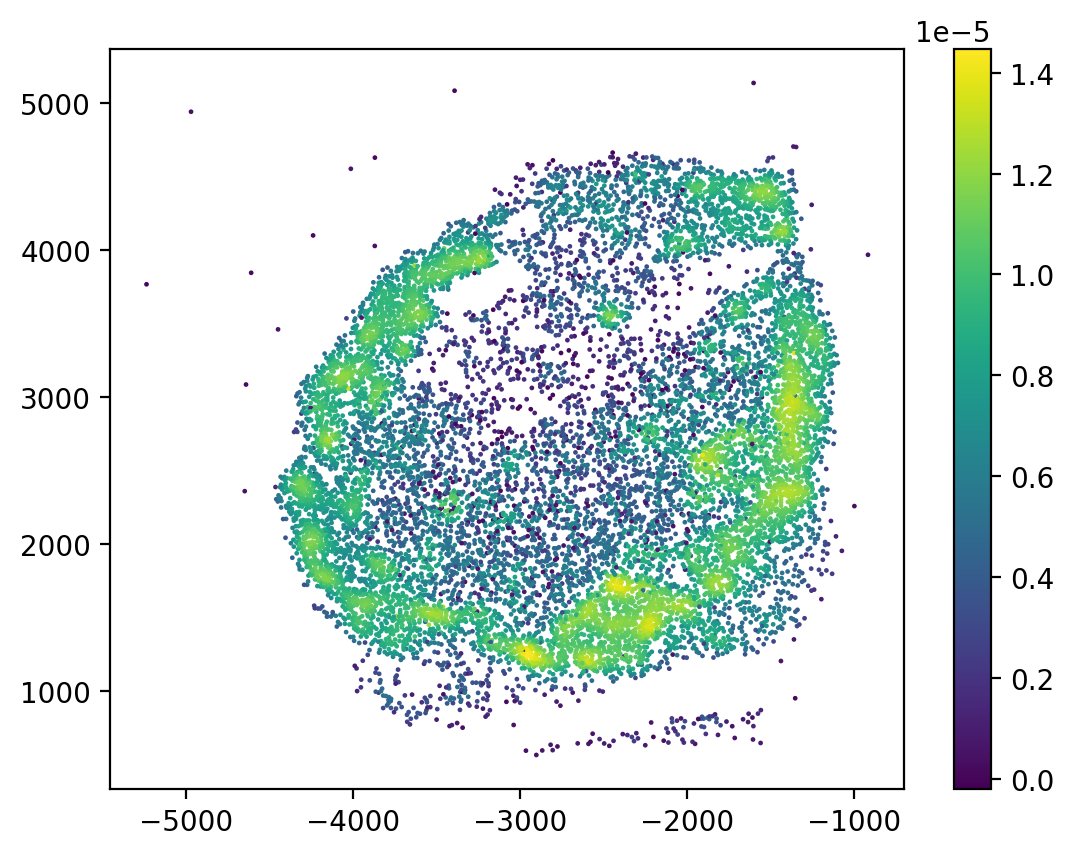

In [21]:
from spaceoracle.plotting.layout import get_modulator_betas

goi_betas_all = get_modulator_betas(so, goi, save_dir=f'.cache/lymph', show=True)

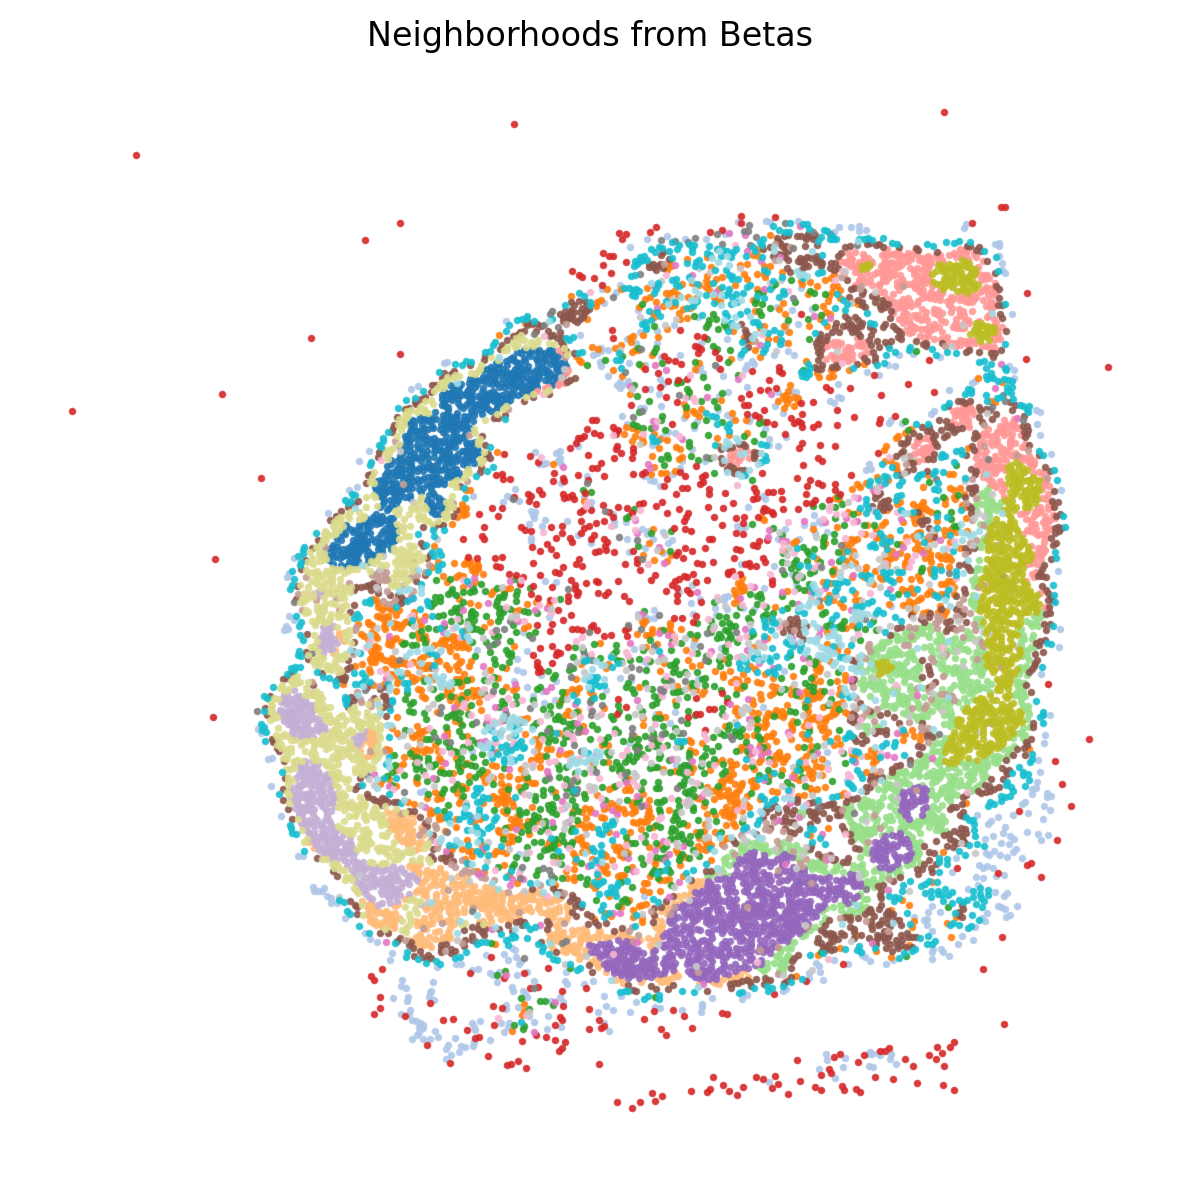

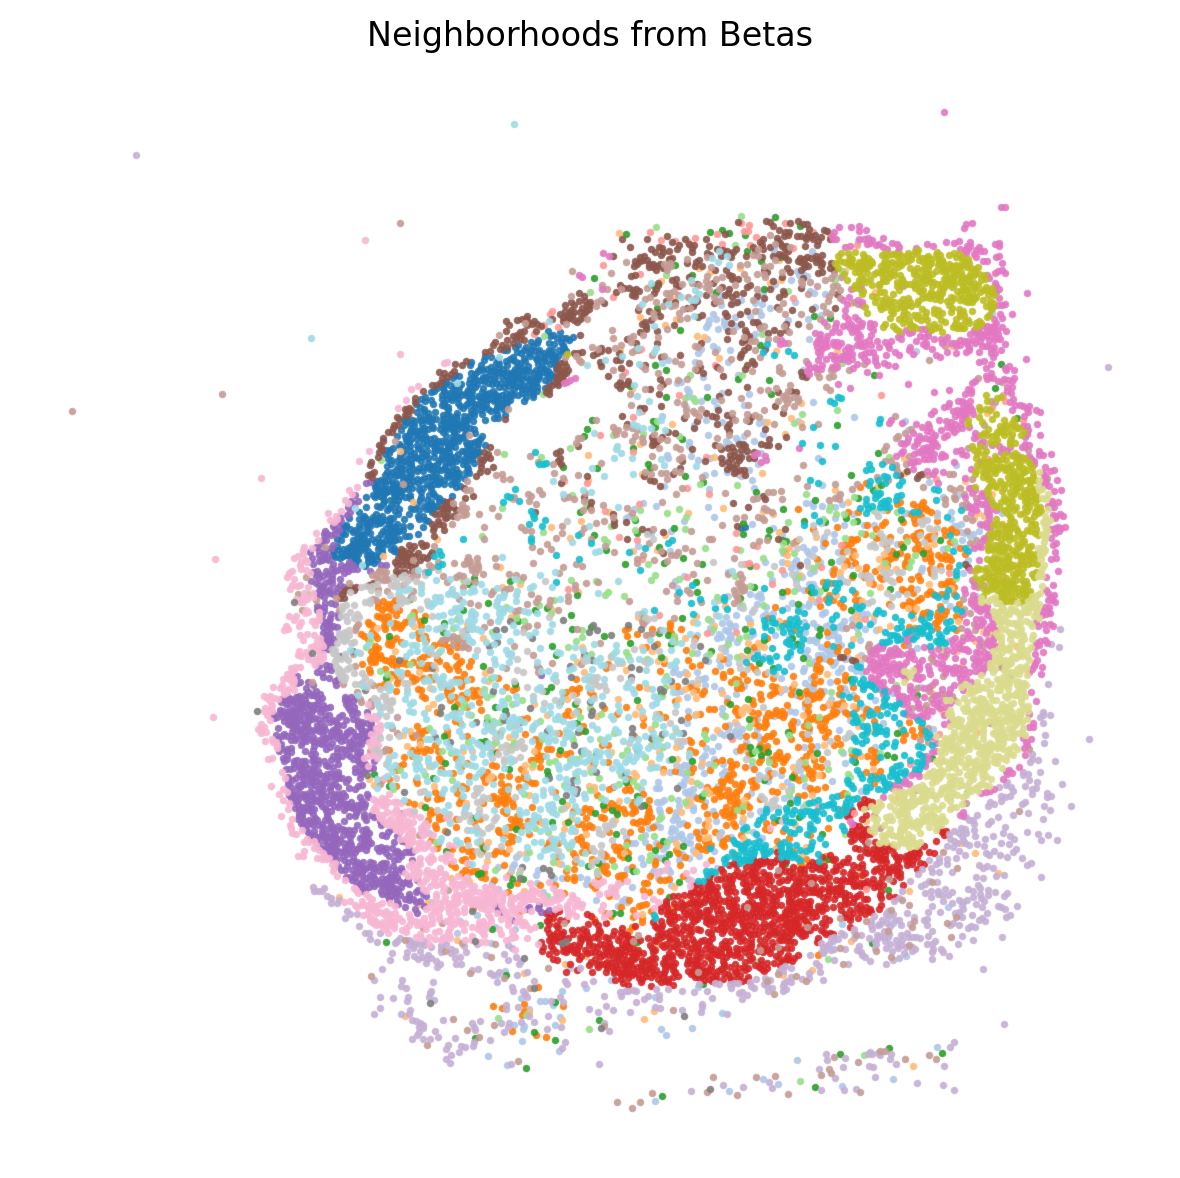

In [52]:
from spaceoracle.plotting.layout import show_beta_neighborhoods

betas = goi_betas_all
_ = show_beta_neighborhoods(adata, betas, nneighborhoods=20)

betas = so.beta_dict[goi].betas.values
_ = show_beta_neighborhoods(adata, betas, nneighborhoods=20)

In [ ]:
betas = goi_betas_all
_ = show_beta_neighborhoods(adata, betas, nneighborhoods=20, split_spatially=True)

betas = so.beta_dict[goi].betas.values
_ = show_beta_neighborhoods(adata, betas, nneighborhoods=20, split_spatially=True)

### Spatial embedding

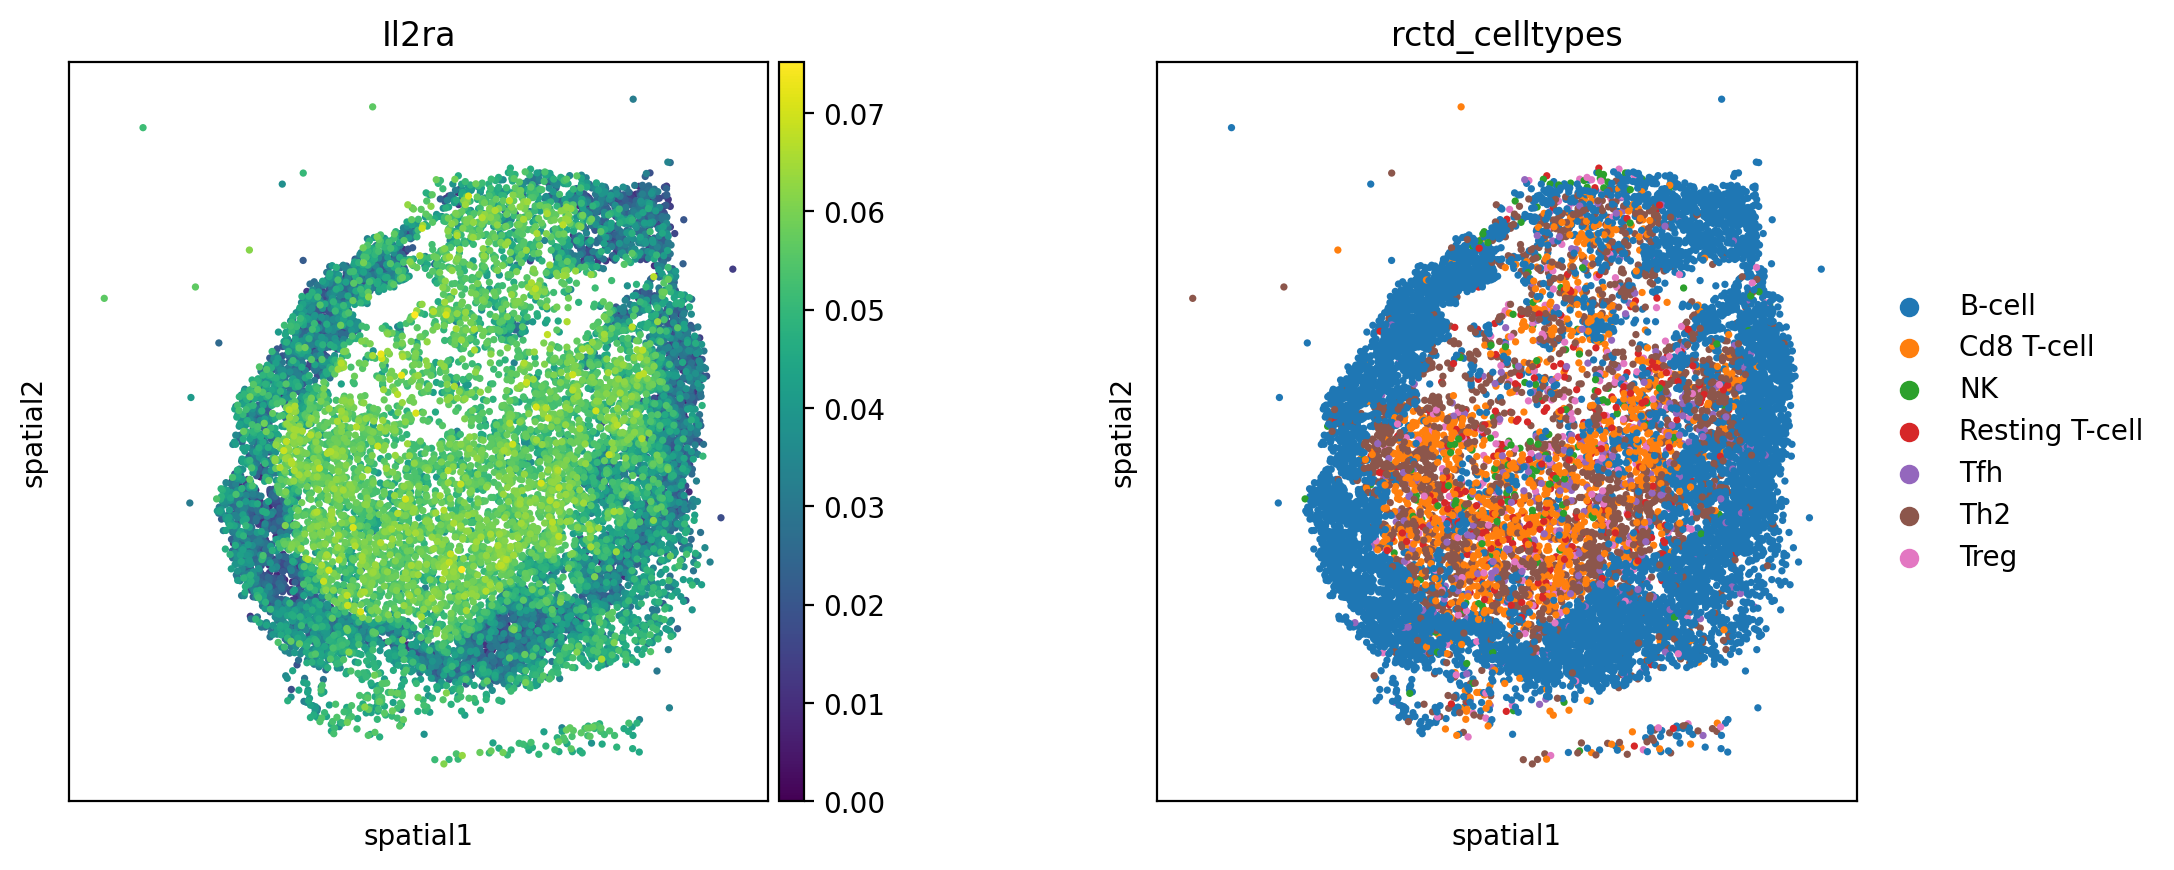

In [ ]:
compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='spatial')

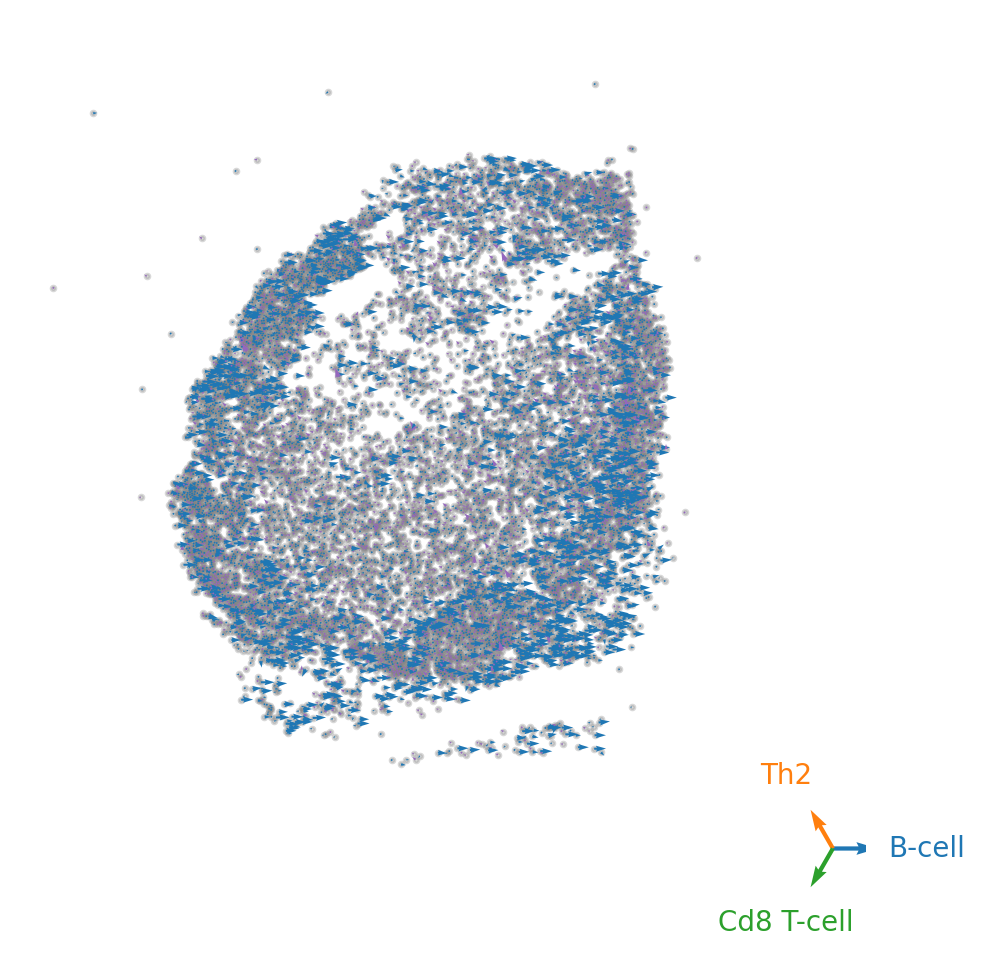

In [60]:
estimate_transitions(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_celltypes', n_neighbors=200, vector_scale=1,
    visual_clusters=['B-cell', 'Th2', 'Cd8 T-cell'], n_jobs=1)

In [ ]:
betas = so.beta_dict[goi].betas.values
group_transitions(so.adata, betas, nneighborhoods=20, vector_scale=1)

betas = goi_betas_all
group_transitions(so.adata, betas, nneighborhoods=20, vector_scale=1)

In [ ]:
randomize_transitions(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_celltypes', n_neighbors=200, vector_scale=10,
    visual_clusters=['B-cell', 'Th2', 'Cd8 T-cell'], 
    renormalize=False, n_jobs=1)

group_transitions(adata, so.beta_dict[goi].betas.values, nneighborhoods=30, vector_scale=10)

In [ ]:
view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], n_jobs=1)

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='Th2', annot='rctd_celltypes', n_jobs=1)

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='B-cell', annot='rctd_celltypes', n_jobs=1)

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='Cd8 T-cell', annot='rctd_celltypes', n_jobs=1)

In [ ]:
randomize_view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], n_jobs=1)

randomize_view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='Th2', annot='rctd_celltypes', n_jobs=1)

randomize_view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='B-cell', annot='rctd_celltypes', n_jobs=1)

randomize_view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='Cd8 T-cell', annot='rctd_celltypes', n_jobs=1)

In [ ]:
# Enforce transitions within nearest neighbors of spatial embedding

from spaceoracle.plotting.transitions import *
from spaceoracle.plotting.randomize import *

estimate_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_cluster', normalize=True, grid_scale=0.01, vector_scale=10, n_jobs=1)

randomize_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_cluster', normalize=True, grid_scale=0.01, vector_scale=10, n_jobs=1)

### FR embedding

In [ ]:
# from spaceoracle.plotting.transitions import *
# from spaceoracle.plotting.randomize import *

# compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='PCA')
# compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='UMAP')
compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='FR')

sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
so.pcs = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)

estimate_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_draw_graph_fr'], 
    annot='rctd_cluster', grid_scale=2, vector_scale=0.5, n_jobs=4)

randomize_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_draw_graph_fr'], 
    annot='rctd_cluster', grid_scale=2, vector_scale=0.5, n_jobs=4)



In [25]:
from spaceoracle.plotting.layout import *

# view_spatial2D(adata, annot='rctd_celltypes')view_spatial3D(adata, annot='rctd_celltypes', show=True, flat=False)

### 3D transitions

In [16]:
celltypes = ['B-cell', 'Cd8 T-cell']

cell_idxs = np.where(adata.obs['rctd_celltypes'].isin(celltypes))[0]
adata_ct = adata[adata.obs_names[cell_idxs]]
delta_X_ct = so.adata.layers['delta_X'][cell_idxs, :]

# view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=True)
embedding_ct = view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=False)

In [ ]:
estimate_transitions_3D(
    adata_ct, delta_X_ct, embedding_ct, annot='rctd_celltypes', 
    normalize=True, grid_scale=0.01, vector_scale=1, n_jobs=1)

In [ ]:
celltypes = ['Th2', 'Cd8 T-cell']

cell_idxs = np.where(adata.obs['rctd_celltypes'].isin(celltypes))[0]

adata_ct = adata[adata.obs_names[cell_idxs]]
delta_X_ct = so.adata.layers['delta_X'][cell_idxs, :]

# view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=True)
embedding_ct = view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=False)

estimate_transitions_3D(
    adata_ct, delta_X_ct, embedding_ct, annot='rctd_celltypes', 
    normalize=True, grid_scale=0.01, vector_scale=1, n_jobs=1)

In [ ]:
from spaceoracle.plotting.similarity import *

plot_similarity_chains(
    so.adata, annot='rctd_cluster', n=5, ax=None, cluster=0, figsize=(6, 6))